In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import torch
from typing import Dict, List, Iterator, Union, Any
import logging
import tempfile
import json
import shutil
from pathlib import Path
from pprint import pprint
from models.utils.wandb import RunData
from models.utils.allennlp import (
    load_config, load_dataset_reader, load_iterator, load_model,load_best_metrics, load_modules, 
    load_outputs, create_onepass_generator)
from allennlp.models import Model
from allennlp.data import DatasetReader, DataIterator
import pandas as pd
from copy import deepcopy
import plotly.graph_objs as go
import numpy as np
from ipywidgets import interact, fixed
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s", level=logging.INFO)

logger = logging.getLogger(__name__)


In [156]:
# config
RUN = 'rmhlaa7z'
EXTRA_MODULES = ['models', 'datasets']
DATA_DIR = '/Users/dhruv/UnsyncedDocuments/IESL/kb_completion/models/.data'
DOWNLOADS_DIR = '.models/HYPO_0'
#DOWNLOADS_DIR = '/var/folders/r2/8mbb22091rb4vq4xtd19bbw80000gn/T/tmp5ypyp_4a'

In [157]:
# get the run files
logger.info("Downloading run files if needed...")
rd = RunData(RUN, group='iesl-boxes', project='kb-completion',
             download_dir=Path(DOWNLOADS_DIR))

rd.download_files(skip_patterns=['allennlp_serialization_dir/metrics_epoch_[\d]+.json$'])

2020-02-13 22:33:02,679 - INFO - __main__ - Downloading run files if needed...
2020-02-13 22:33:03,328 - INFO - models.utils.wandb - Setting up download dir as .models/HYPO_0/rmhlaa7z
2020-02-13 22:33:03,525 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/best.th
2020-02-13 22:33:04,917 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/config.json
2020-02-13 22:33:05,501 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/log/train/events.out.tfevents.1581556112.node163
2020-02-13 22:33:08,301 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/metrics.json
2020-02-13 22:33:13,386 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/model.tar.gz
2020-02-13 22:33:14,750 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/model_state_epoch_896.th
2020-02-13 22:33:16,843 - INFO - models.utils.wandb - Downloading allennlp_serialization_dir/stderr.log
2020-02-13 22:33:18,644 - INFO - m

In [158]:

# load modules
logger.info("Loading {} for AllenNLP".format(EXTRA_MODULES))
load_modules(EXTRA_MODULES)

# override the val dataset setup to become the test dataset setup
overrides = {'validation_dataset_reader':
             {
                 'all_datadir': DATA_DIR,
                 "validation_file": "classification_samples_test2id.txt"
             }
            }
logger.info("Setting up config overrides ...")

# load config
config = load_config(
    rd.download_dir/"allennlp_serialization_dir", overrides_dict=overrides)
#pprint(config.as_dict())

# load best metrics
#best_metrics = load_best_metrics(rd.download_dir/"allennlp_serialization_dir")
# load model
model = load_model(rd.download_dir/"allennlp_serialization_dir", config=config)
#model.test_threshold = best_metrics['best_validation_threshold']
model.test_threshold =-5.59



2020-02-13 22:33:26,098 - INFO - __main__ - Loading ['models', 'datasets'] for AllenNLP
2020-02-13 22:33:26,225 - INFO - __main__ - Setting up config overrides ...
2020-02-13 22:33:26,262 - INFO - allennlp.common.params - Converting Params object to dict; logging of default values will not occur when dictionary parameters are used subsequently.
2020-02-13 22:33:26,263 - INFO - allennlp.common.params - CURRENTLY DEFINED PARAMETERS: 
2020-02-13 22:33:26,263 - INFO - allennlp.common.params - datasets_for_vocab_creation = []
2020-02-13 22:33:26,265 - INFO - allennlp.common.params - iterator.batch_size = 2000
2020-02-13 22:33:26,267 - INFO - allennlp.common.params - iterator.cache_instances = True
2020-02-13 22:33:26,268 - INFO - allennlp.common.params - iterator.type = basic
2020-02-13 22:33:26,269 - INFO - allennlp.common.params - train_data_path = dummpy_path
2020-02-13 22:33:26,269 - INFO - allennlp.common.params - dataset_reader.all_datadir = /mnt/nfs/work1/mccallum/dhruveshpate/kb_com

In [159]:
vols = ((model.h.get_volumes(temp=model.softbox_temp).detach()).tolist())

In [160]:
# read idx depth
idx2dept = {}
depths = []

with open('/Users/dhruv/Downloads/dept_map.txt') as f:
    for line in f:
        name, idx, depth = line.split()
        idx2dept[int(idx)]=int(depth)
        depths.append(int(depth))

In [161]:
from matplotlib import pyplot as plt

In [162]:
truck_depth = [9  if d > 8.5 else d for d in depths ]

(array([0.0000e+00, 3.0000e+00, 2.2000e+01, 2.2300e+02, 1.5410e+03,
        4.5730e+03, 8.1740e+03, 1.4831e+04, 5.2747e+04]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

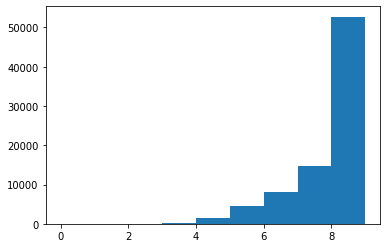

In [95]:
plt.hist(truck_depth,bins=range(0,10))

In [88]:
vols.max()

35884.871369224085

(array([5.765e+03, 2.384e+03, 1.171e+03, 7.160e+02, 5.060e+02, 4.320e+02,
        4.130e+02, 3.880e+02, 4.400e+02, 4.730e+02, 5.140e+02, 4.930e+02,
        5.010e+02, 4.990e+02, 5.110e+02, 4.910e+02, 4.850e+02, 5.040e+02,
        4.620e+02, 4.560e+02, 4.950e+02, 4.150e+02, 3.990e+02, 4.450e+02,
        4.120e+02, 3.900e+02, 3.850e+02, 4.370e+02, 3.950e+02, 3.540e+02,
        3.700e+02, 3.660e+02, 3.190e+02, 3.430e+02, 3.230e+02, 2.780e+02,
        2.880e+02, 2.960e+02, 2.350e+02, 2.650e+02, 2.400e+02, 2.500e+02,
        2.180e+02, 2.300e+02, 2.380e+02, 2.010e+02, 1.820e+02, 1.560e+02,
        1.630e+02, 1.660e+02, 1.480e+02, 1.360e+02, 9.900e+01, 1.100e+02,
        1.090e+02, 9.600e+01, 1.130e+02, 9.400e+01, 9.400e+01, 6.600e+01,
        6.900e+01, 5.900e+01, 4.900e+01, 5.200e+01, 4.200e+01, 4.200e+01,
        2.400e+01, 4.000e+01, 3.200e+01, 2.900e+01, 3.400e+01, 2.400e+01,
        1.900e+01, 1.800e+01, 2.200e+01, 2.000e+01, 9.000e+00, 1.100e+01,
        9.000e+00, 1.800e+01, 1.300e+0

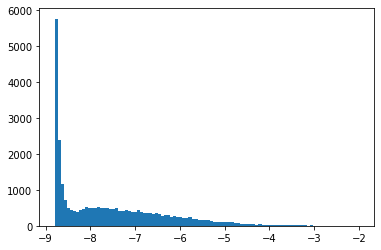

In [94]:
plt.hist(vols, bins=100, range=(-8.8,-2))

In [99]:
import plotly.express as px
df = px.data.tips()
import pandas as pd

In [137]:
fig = px.histogram(df, x='log volume', range_x=(-8.8,-2), range_y=(0, 18000), labels=dict(x='sdf'))
fig.show()

In [152]:
fig = px.histogram(df, x='log volume', range_x=(-8.82,-2),nbins=1000)
fig.show()

In [109]:
df = pd.DataFrame(vols, columns=['log volume'])

In [153]:
depdf = pd.DataFrame(depths, columns=['depth'])

In [155]:
fig = px.histogram(depdf, x='depth')
fig.show()